In [121]:
# Login
import wrds
db = wrds.Connection(wrds_username="hanyuzhang")
# password is Timeseries2020!

Enter your WRDS username [liyf4]:hanyuzhang
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [122]:
# Preprocess Data
import pandas as pd
sym_df = pd.read_csv("Ticker.csv", header=0)
sym_list = sym_df["Ticker"].tolist()
sym_permno_list = list()
for symbol in sym_list:
    if len(symbol) == 0:
        continue
    result = db.raw_sql(f"""select permno, htsymbol 
                           from crsp.dsfhdr 
                           where htsymbol = '{symbol}'""")
    try:
        sym_permno_list.append((result.iloc[0]['permno'], result.iloc[0]['htsymbol']))
    except:
        print(f"wrds doesn't have data for {symbol} right now, skip...")

wrds doesn't have data for ATT right now, skip...
wrds doesn't have data for RTX right now, skip...


In [123]:
from collections import defaultdict
timeseries_bank = defaultdict(list)
for permno, symbol in sym_permno_list:
    result = db.raw_sql(f"""select date, prc, cfacpr
                            from crsp.dsf
                            where permno = {permno} and date > '2010-01-01'
                         """)
    ts = {date:prc for date, prc in zip(result["date"].tolist(), (result["prc"]/result["cfacpr"]).tolist())}
    timeseries_bank[symbol] = ts  

In [124]:

# Build pairs
sym_pairs = list()
sym_pairs_ts = dict()
valid_sym_list = list(timeseries_bank.keys())
for i in range(len(valid_sym_list)-1):
    for j in range(i+1, len(valid_sym_list)):
        sym_pairs.append((valid_sym_list[i], valid_sym_list[j]))
for pair in sym_pairs:
    sym_pairs_ts[pair] = {"first":timeseries_bank[pair[0]], "second":timeseries_bank[pair[1]]}
    
# sym_paris_ts is the pair timeseries:
# {(sym1, sym2):{'first':[(datetime.date(2010,1,1),price1), (datetime.date(2010,1,2):price2), ...}, "second":[...]}}

In [68]:
# Back Test Framework
# utility function
def cal_spread(first, second)->float:
    pass

def test(sym1_ts, sym2_ts, start_date, sigma, mean, half_life):
    open_price = 0
    close_price = 0
    opened = False
    open_date = None
    from dateutil.relativedelta import relativedelta
    end_date = start_date + relativedelta(months=3)
    curr_date = start_date
    while curr_date < end_date:
        if curr_date not in sym1_ts or curr_date not in sym2_ts:
            curr_date += relativedelta(days=1)
            continue
        spread = cal_spread(sym1_ts[curr_date], sym2_ts[curr_date])
        if spread > 2*sigma + mean and end_date - curr_date > datetime.timedelta(days = 2 * half_life) and not opened:
            opened = True
            open_date = curr_date
            open_price = sym1_ts[curr_date]-sym2_ts[curr_date]
        # trade close
        # add factor correlation?
        elif opened and (spread <= mean or curr_date - open_date > datetime.timedelta(days = 3 * half_life)):
            close_price = sym1_ts[curr_date]-sym2_ts[curr_date]
            opened = False
            break
        curr_date += relativedelta(days=1)
    if opened:
        curr_date -= relativedelta(days=1)
        close_price = sym1_ts[curr_date]-sym2_ts[curr_date]
        opened = False
    return close_price - open_price            

In [30]:
import numpy as np
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import pandas as pd
def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')

In [83]:

t1=np.log(np.array(list(timeseries_bank["XOM"].values())[-100:]).flatten())
t2=np.log(np.array(list(timeseries_bank["CVX"].values())[-100:]).flatten())
t3=np.array(list(timeseries_bank["GS"].values())[-250:]).flatten()
t4=np.array(list(timeseries_bank["JPM"].values())[-250:]).flatten()
t1=t1/t1[0]
t2=t2/t2[0]
t3=t3/t3[0]
t4=t4/t4[0]

In [84]:
result1=ts.coint(t3,t4)

In [85]:
result1

(-3.624054486555347,
 0.02287139457226645,
 array([-3.94096428, -3.3607786 , -3.0615268 ]))

In [86]:

df=pd.DataFrame([t1,t2]).T

In [132]:
result2=coint_johansen(np.array([t1,t2]).T, det_order=0, k_ar_diff=1)

In [133]:
joh_output(result2)

   max_eig_stat  trace_stat
0     15.457204   23.161618
1      7.704414    7.704414 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]] 



In [89]:
result2.lr1

array([23.1616179 ,  7.70441419])

In [90]:
result2.cvt

array([[13.4294, 15.4943, 19.9349],
       [ 2.7055,  3.8415,  6.6349]])

In [91]:
result2.trace_stat_crit_vals[:,0]

array([13.4294,  2.7055])

In [92]:
np.all(result2.lr1>=result2.trace_stat_crit_vals[:,0])

True

In [93]:
t1

array([1.        , 0.9959562 , 0.99883745, 0.98918502, 0.98779306,
       0.9914295 , 0.99534865, 0.99392488, 0.9962594 , 0.99575387,
       0.98862922, 0.98987791, 0.98758356, 0.98928908, 0.99187582,
       0.99204727, 0.9923213 , 0.99480729, 0.99810375, 1.00029803,
       1.00214387, 1.00404047, 1.00358407, 1.00374718, 1.00588955,
       1.00938546, 1.00759589, 1.00647045, 1.00488572, 1.00407304,
       1.00423579, 1.00099192, 1.00168377, 1.00043036, 1.00211105,
       0.9992367 , 0.9936527 , 0.98744378, 0.99032721, 0.99372079,
       0.99046526, 0.98586552, 0.98845528, 0.9912576 , 0.99375482,
       0.99443437, 0.99524724, 0.99118882, 0.99087899, 0.9890462 ,
       0.99293673, 0.9941288 , 0.99636038, 0.9941288 , 0.99467175,
       0.99259503, 0.99191013, 0.98942777, 0.98890728, 0.99585506,
       1.00273411, 1.00733912, 1.00214387, 1.00708209, 0.99976795,
       0.99833745, 0.99507814, 0.99314153, 0.9921158 , 0.9944683 ,
       0.99218431, 0.98977411, 0.99049977, 0.996091  , 0.99507

<AxesSubplot:>

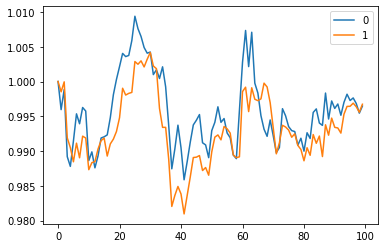

In [94]:
df.plot()

<AxesSubplot:>

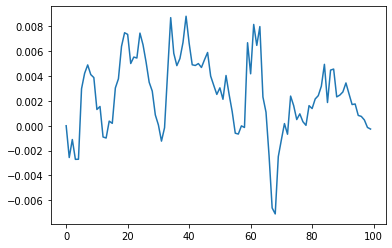

In [98]:
(df[0]-df[1]).plot()

In [96]:
df

,0,1
0,1.000000,1.000000
1,0.995956,0.998516
2,0.998837,0.999949
3,0.989185,0.991892
4,0.987793,0.990492
...,...,...
95,0.997267,0.996435
96,0.997636,0.996884
97,0.996831,0.996366
98,0.995450,0.995587


In [99]:
df.corr()

,0,1
0,1.000000,0.816597
1,0.816597,1.000000


In [105]:
np.log(1+pd.DataFrame(list(timeseries_bank["XOM"].values())[-100:]).pct_change())

,0
0,NaN
1,-0.017228
2,0.012275
3,-0.041123
4,-0.005930
...,...
95,-0.003849
96,0.001570
97,-0.003428
98,-0.005884


In [109]:
df_return=pd.DataFrame([list(timeseries_bank["XOM"].values()),list(timeseries_bank["CVX"].values())]).T

In [110]:
df_return=np.log(1+df_return.pct_change().dropna())

In [112]:
df_return.corr()

,0,1
0,1.000000,0.792505
1,0.792505,1.000000


In [116]:
table=db.describe_table('comp', 'funda')

Approximately 822926 rows in comp.funda.


In [119]:
for i in table["name"].values:
    print(i)


gvkey
datadate
fyear
indfmt
consol
popsrc
datafmt
tic
cusip
conm
acctchg
acctstd
acqmeth
adrr
ajex
ajp
bspr
compst
curcd
curncd
currtr
curuscn
final
fyr
ismod
ltcm
ogm
pddur
scf
src
stalt
udpl
upd
apdedate
fdate
pdate
acchg
acco
accrt
acdo
aco
acodo
acominc
acox
acoxar
acqao
acqcshi
acqgdwl
acqic
acqintan
acqinvt
acqlntal
acqniintc
acqppe
acqsc
act
adpac
aedi
afudcc
afudci
aldo
am
amc
amdc
amgw
ano
ao
aocidergl
aociother
aocipen
aocisecgl
aodo
aol2
aoloch
aox
ap
apalch
apb
apc
apofs
aqa
aqc
aqd
aqeps
aqi
aqp
aqpl1
aqs
arb
arc
arce
arced
arceeps
artfs
at
aul3
autxr
balr
banlr
bast
bastr
batr
bcef
bclr
bcltbl
bcnlr
bcrbl
bct
bctbl
bctr
billexce
bkvlps
bltbl
ca
capr1
capr2
capr3
caps
capsft
capx
capxv
cb
cbi
cdpac
cdvc
ceiexbill
ceq
ceql
ceqt
cfbd
cfere
cfo
cfpdo
cga
cgri
cgti
cgui
ch
che
chech
chs
ci
cibegni
cicurr
cidergl
cimii
ciother
cipen
cisecgl
citotal
cld2
cld3
cld4
cld5
clfc
clfx
clg
clis
cll
cllc
clo
clrll
clt
cmp
cnltbl
cogs
cpcbl
cpdoi
cpnli
cppbl
cprei
crv
crvnli
cshfd
cshi
c

In [125]:
len(timeseries_bank)

29

In [126]:
from sklearn.decomposition import PCA

In [127]:
pca = PCA(n_components=4)

In [131]:
np.array([t1,t2]).T

array([[1.        , 1.        ],
       [0.9959562 , 0.99851647],
       [0.99883745, 0.99994902],
       [0.98918502, 0.99189198],
       [0.98779306, 0.99049159],
       [0.9914295 , 0.98845401],
       [0.99534865, 0.99113091],
       [0.99392488, 0.98902798],
       [0.9962594 , 0.99213917],
       [0.99575387, 0.99187432],
       [0.98862922, 0.98731937],
       [0.98987791, 0.98832825],
       [0.98758356, 0.98848994],
       [0.98928908, 0.99027806],
       [0.99187582, 0.99150294],
       [0.99204727, 0.99185665],
       [0.9923213 , 0.9892786 ],
       [0.99480729, 0.9910245 ],
       [0.99810375, 0.99171524],
       [1.00029803, 0.99280865],
       [1.00214387, 0.99478679],
       [1.00404047, 0.99902922],
       [1.00358407, 0.99805389],
       [1.00374718, 0.99829387],
       [1.00588955, 0.99843088],
       [1.00938546, 1.00286869],
       [1.00759589, 1.00248288],
       [1.00647045, 1.00296922],
       [1.00488572, 1.00209636],
       [1.00407304, 1.00320359],
       [1.